In [11]:
!git clone https://github.com/NVIDIA/apex
!pip install -v --no-cache-dir --global-option="--cpp_ext" ./apex

Cloning into 'apex'...
    Running command python setup.py egg_info


    torch.__version__  = 1.6.0


    running egg_info
    creating C:\Users\victo\AppData\Local\Temp\pip-pip-egg-info-f9ubpy_0\apex.egg-info
    writing C:\Users\victo\AppData\Local\Temp\pip-pip-egg-info-f9ubpy_0\apex.egg-info\PKG-INFO
    writing dependency_links to C:\Users\victo\AppData\Local\Temp\pip-pip-egg-info-f9ubpy_0\apex.egg-info\dependency_links.txt
    writing top-level names to C:\Users\victo\AppData\Local\Temp\pip-pip-egg-info-f9ubpy_0\apex.egg-info\top_level.txt
    writing manifest file 'C:\Users\victo\AppData\Local\Temp\pip-pip-egg-info-f9ubpy_0\apex.egg-info\SOURCES.txt'
    reading manifest file 'C:\Users\victo\AppData\Local\Temp\pip-pip-egg-info-f9ubpy_0\apex.egg-info\SOURCES.txt'
    writing manifest file 'C:\Users\victo\AppData\Local\Temp\pip-pip-egg-info-f9ubpy_0\apex.egg-info\SOURCES.txt'
    Running command 'c:\repos\geneticengineeringattributionchallenge\env\scripts\python.exe' -u -c 'import

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from torch.nn.utils.rnn import pad_sequence

import transformers

import sklearn.metrics
from tqdm.notebook import tqdm

from pathlib import Path

In [2]:
train = pd.read_csv('../data/processed/train.csv')
test = pd.read_csv('../data/processed/test.csv')
print('Train: ',train.shape)
print('Test: ',test.shape)

Train:  (67447, 43)
Test:  (18816, 42)


CREATE CORPUS

In [3]:
filename = Path('../data/features/bert/corpus.txt')

with open(filename,'w+') as f:
    for i in tqdm(range(len(train)),total=len(train)):
        for x in train["sequence"].values[i]:
            f.write(x)
        f.write('\n')
    for i in tqdm(range(len(test)),total=len(test)):
        for x in test["sequence"].values[i]:
            f.write(x)
        f.write('\n')

KeyboardInterrupt: 

In [4]:
%%time
from tokenizers import ByteLevelBPETokenizer

# Initialize a tokenizer
tokenizer = ByteLevelBPETokenizer()

# Customize training
tokenizer.train(files='../data/features/bert/corpus.txt', vocab_size=2500, min_frequency=5, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])

Wall time: 32min 34s


In [5]:
tokenizer.save_model('../data/features/bert/tok/')

['../data/features/bert/tok/vocab.json',
 '../data/features/bert/tok/merges.txt']

In [6]:
from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained("../data/features/bert/tok/")

sequences = pd.concat([train.sequence,test.sequence],axis=0).values

max_len = 0

lenghts = []

for seq in tqdm(sequences,total=len(sequences)):
    input_ids = tokenizer.encode(seq, add_special_tokens=True)
    l = len(input_ids)
    max_len = max(max_len, l)
    lenghts.append(l)
    
print(max_len)


14199


<AxesSubplot:>

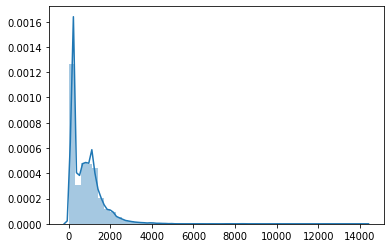

In [7]:
import seaborn as sns 
sns.distplot(lenghts)

In [8]:
np.percentile(lenghts,90)

1701.0

In [3]:
from transformers import RobertaConfig
from transformers import RobertaTokenizerFast
from linformer_pytorch import LinformerLM, Padder

config = {
    "vocab_size": 2500,
    "hidden_size":240,
    "num_hidden_layers":6,
    "num_attention_heads":12,
    "intermediate_size":480,
    "max_position_embeddings":1502,
    "type_vocab_size":1,
}

tokenizer = RobertaTokenizerFast.from_pretrained("../data/features/bert/tok/", max_len=1500)

from transformers import RobertaForMaskedLM

model = RobertaForMaskedLM(RobertaConfig(**config))


In [4]:
model.num_parameters()

3860500

In [5]:
%%time
from transformers import LineByLineTextDataset

dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path='../data/features/bert/corpus.txt',
    block_size=1500
)

Wall time: 12min 27s


In [6]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

In [7]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="../data/features/bert/model/",
    overwrite_output_dir=True,
    learning_rate=1e-3,
    num_train_epochs=5,
    evaluate_during_training=True,
    do_train=True,
    gradient_accumulation_steps=8,
    per_gpu_train_batch_size=2,
    per_gpu_eval_batch_size=2,
    logging_steps=100,
    warmup_steps= 10,
    save_steps=250,
    save_total_limit=1,
    fp16=True,

)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
    eval_dataset=dataset,
    prediction_loss_only=False,
)

In [8]:
from apex import amp

In [9]:
%%time
trainer.train()

Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Iteration:   0%|          | 0/43132 [00:00<?, ?it/s]Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         :

In [11]:
trainer.save_model("../data/features/bert/model/")

In [3]:
labs = pd.read_csv('../data/raw/train_labels.csv').columns[1:]

lab_pos = dict()
i = 0
for lab in labs:
    lab_pos[lab]=i

def get_targets(y):
    targets = []
    for lab in y:
        tmp = np.zeros(len(labs))
        idx = lab_pos[lab]
        tmp[idx] = 1
        targets.append(tmp)
    targets = torch.tensor(targets)
    print('targets: ',targets.shape)
    return targets

In [4]:
from sklearn.model_selection import train_test_split

X = train['sequence'].tolist()
y = get_targets(train['target'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, stratify=y, random_state=420)

X_test = test['sequence'].tolist()

targets:  torch.Size([67447, 1314])


In [5]:
from transformers import RobertaModel
from transformers import RobertaConfig

import torch
import multiprocessing as mp

In [6]:
%load_ext autoreload
%autoreload 2
import aux_w
import itertools

from transformers import RobertaTokenizerFast
class data_class:

    def __init__(self,sequences,targets,test=False):
        self.input_ids = []
        self.attention_mask = []
        self.targets = []

        sequences = sequences[0:30]

        self.tokenizer = RobertaTokenizerFast.from_pretrained("../data/features/bert/tok/",max_len=1500) 

        pool = mp.Pool(10)

        if(test):
            targets = np.arange(0,len(sequences)).tolist()

        with tqdm(total=len(sequences)) as pbar:

            for i, row in enumerate(pool.imap_unordered(aux_w.tokenize_worker2, zip(sequences,targets,itertools.repeat(self.tokenizer)))):
                self.input_ids.append(row[0]['input_ids'])
                self.attention_mask.append(row[0]['attention_mask'])
                if test:
                    self.targets.append(torch.tensor(row[1]))
                else:
                    self.targets.append(row[1])
                pbar.update(1)

        pool.close()
        pool.join()
                
        self.input_ids = torch.cat(self.input_ids, dim=0)
        self.attention_mask = torch.cat(self.attention_mask, dim=0)
        self.targets = torch.stack(self.targets)

        print(self.input_ids.shape)
        print(self.attention_mask.shape)
        print(self.targets.shape)

In [7]:
train_dataset = data_class(X_train,y_train)
train_dataset = torch.utils.data.TensorDataset(train_dataset.input_ids,train_dataset.attention_mask,train_dataset.targets)

valid_dataset = data_class(X_valid,y_valid)
valid_dataset = torch.utils.data.TensorDataset(valid_dataset.input_ids,valid_dataset.attention_mask,valid_dataset.targets)

test_dataset = data_class(X_test,None,test=True)
test_dataset = torch.utils.data.TensorDataset(test_dataset.input_ids,test_dataset.attention_mask,test_dataset.targets)


torch.Size([30, 1500])
torch.Size([30, 1500])
torch.Size([30, 1314])



torch.Size([30, 1500])
torch.Size([30, 1500])
torch.Size([30, 1314])



torch.Size([30, 1500])
torch.Size([30, 1500])
torch.Size([30])


In [8]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    sampler=torch.utils.data.RandomSampler(train_dataset),
    batch_size=1,
    num_workers=1
)

valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset,
    sampler=torch.utils.data.SequentialSampler(valid_dataset),
    batch_size=1,
    num_workers=1
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    sampler=torch.utils.data.SequentialSampler(test_dataset),
    batch_size=1,
    num_workers=1
)

In [14]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.n_classes = 1314

        self.roberta = RobertaModel.from_pretrained('../data/features/bert/model/checkpoint-500/')

        self.cls = nn.Linear(240,self.n_classes)

    def forward(self,input_ids,attention_mask):

        x = self.roberta(input_ids,attention_mask)[0][:,0,:]
        x = self.cls(x)

        return x

In [15]:
device = torch.device('cpu')

model = Net().to(device)

In [16]:
model

Net(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(2500, 240, padding_idx=1)
      (position_embeddings): Embedding(1502, 240, padding_idx=1)
      (token_type_embeddings): Embedding(1, 240)
      (LayerNorm): LayerNorm((240,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=240, out_features=240, bias=True)
              (key): Linear(in_features=240, out_features=240, bias=True)
              (value): Linear(in_features=240, out_features=240, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=240, out_features=240, bias=True)
              (LayerNorm): LayerNorm((240,), eps=1e-12, elementwi

In [17]:
from sklearn import metrics

epochs = 4

optimizer = torch.optim.AdamW(
            model.parameters(),
            lr = 3e-5
        )

criterion = nn.BCEWithLogitsLoss()

In [18]:
print('TRAINING...')

training_stats = []

total_steps = 0

with tqdm(total=epochs,leave=False) as pbar:
  for epoch_i in range(0, epochs):

    total_train_loss = 0
    model.train()

    optimizer.zero_grad() 

    logits = []
    ground_truth = []

    for step, batch in tqdm(enumerate(train_dataloader),total=len(train_dataloader),leave=False):

        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)

        b_labels = batch[2]

        with torch.cuda.amp.autocast():
          b_logits = model(input_ids, attention_mask).cpu()

          logits.extend(b_logits)
          ground_truth.extend(b_labels.detach().numpy())      

          loss = criterion(b_logits.float(),b_labels)
        total_train_loss += loss.item()

        loss.cuda()

        optimizer.step()

    y_probas = nn.Softmax(dim=0)(torch.stack(logits).float())
    y_labels = y_probas.round()

    train_auc = round(metrics.roc_auc_score(ground_truth,y_probas.detach().numpy()),3)
    train_acc = round(metrics.accuracy_score(ground_truth,y_labels.detach().numpy()),3)

    model.eval()

    total_dev_loss = 0

    logits = []
    ground_truth = []
            
    for step, batch in enumerate(valid_dataloader):

        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)

        b_labels = batch[2]

        with torch.cuda.amp.autocast():
          b_logits = model(input_ids, attention_mask).cpu()

          logits.extend(b_logits)
          ground_truth.extend(b_labels.detach().numpy())

          loss = criterion(b_logits.float(),b_labels)

        total_dev_loss += loss.item()


    y_probas = nn.Softmax(dim=0)(torch.stack(logits).float())
    y_labels = y_probas.round()

    test_auc = round(metrics.roc_auc_score(ground_truth,y_probas.detach().numpy()),3)
    test_acc = round(metrics.accuracy_score(ground_truth,y_labels.detach().numpy()),3)
    avg_dev_loss = total_dev_loss/len(test_dataloader)


    training_stats.append(
        {
            'train_loss': avg_train_loss,
            'dev_loss': avg_dev_loss,
            'train_acc': train_acc,
            'train_auc': train_auc,
            'dev_acc': test_acc,
            'dev_auc': test_auc
        }
      )
    
    pbar.update(1)

    print('\nEpoch: ',epoch_i,'train_loss ',avg_train_loss,
            ' dev_loss ',avg_dev_loss,
            ' train_acc ',train_acc,
            ' train_auc ',train_auc,
            ' dev_acc ',test_acc,
            ' dev_auc ',test_auc)

TRAINING...


In [ ]:
# Show training results
col_names = ['train_loss','train_acc','train_auc','dev_loss', 'dev_acc','dev_auc']
training_stats = pd.DataFrame(training_stats,columns=col_names)
print(training_stats.head(epochs))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def make_plot(train_serie, dev_serie,x,y='Epoch',l_s1='Training',l_s2='Validation',title="Training & Validation"):

    sns.set(style='darkgrid')

    sns.set(font_scale=1.5)

    plt.close()

    plt.rcParams["figure.figsize"] = (12,6)

    plt.plot(train_serie, 'b-o', label=l_s1)
    plt.plot(dev_serie, 'g-o', label=l_s2)

    plt.title(title)
    plt.xlabel(y)
    plt.ylabel(x)
    plt.legend()
    plt.xticks(np.arange(train_serie.shape[0]))

    plt.show() 

In [ ]:
make_plot(training_stats['train_loss'],training_stats['dev_loss'],x='Loss')

In [ ]:
make_plot(training_stats['train_acc'],training_stats['dev_acc'],x='Accuracy')

In [ ]:
make_plot(training_stats['train_auc'],training_stats['dev_auc'],x='Area Under Curve')